# ACROBOT
---
Acrobot es un pequeno robot conformado por dos brazos creando un pendulo. El objetivo del robot es que pase una altura predefinida, solamente utilizando 3 acciones distintas, Empujar a la derecha, Empujar a la izquierda y no hacer nada, con estas acciones es suficiente para que el robot empiece a columpearse y tomar velocidad rotacional para subir hasta la linea objetivo.

In [1]:
using PyCall
using PyPlot
ioff()

# librerias
---
Utilizaremos librerias de python, ya que el sistema operativo que utilizo no permite utilizar OpenAIGym con Julia, esto reducira dramaticamente nuestra eficiencia y probablemente haga el entrenamiento mas lento y menos eficiente.

In [2]:
@pyimport numpy as np
@pyimport gym

Rectangle = pyimport("matplotlib.patches")["Rectangle"]

plt[:style][:use]("ggplot")
Rectangle

PyObject <class 'matplotlib.patches.Rectangle'>

# Inicializar environment
---
rapidamente creamos nuestro environment del acrobot y aprovecharemos la oportunidad para imprimir cual es valor mas alto que toman sus estados, el mas bajo y el numero de acciones que hay. Esto sera util mas adelante para poder crear nuestra tabla q y definir nuestras acciones

In [3]:
env = gym.make("Acrobot-v1")
 
env[:seed](505);
println("State space: ", env[:observation_space])

println("-  low: ", env[:observation_space][:low])

println("- high: ", env[:observation_space][:high])
println("Action space: ", env[:action_space])

State space: PyObject Box(6,)
-  low: Float32[-1.0, -1.0, -1.0, -1.0, -12.5664, -28.2743]
- high: Float32[1.0, 1.0, 1.0, 1.0, 12.5664, 28.2743]
Action space: PyObject Discrete(3)


# crear un tiling grid
---
A un tiling le llamamos un lugar en donde podremos encontrar un conjunto infinito de estados ya que estos estan en un espacio continuo.
Esta funcion es bastante sencilla, dados n lows, n highs, n tamanos do bins y n offsets, regresamos arreglos del tamano de los bins haciendo divisiones uniformes entre low[n] y high[n] con el offset[n] agregado.

In [4]:
function create_tiling_grid(low, high, bins = (10, 10), offsets = (0.0, 0.0))

    
    grid = [collect(range(low[dim], stop = high[dim], length = bins[dim] + 1))[2:end-1] for dim in 1:length(bins)]

    for i in 1:length(bins)
        for j in 1:bins[1]-1
            grid[i][j] = grid[i][j] + offsets[i]
        end
    end
    println("Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>")
    for (l, h, b, o, splits) in zip(low, high, bins, offsets, grid)
        println("    [$l, $h]/$b + ($o) => $splits")
    end
    return grid
end
low = [-1.0, -5.0]
high = [1.0, 5.0]

create_tiling_grid(low, high, (10, 10), (-0.1, 0.5));  # [test]

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0]/10 + (-0.1) => [-0.9, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7]
    [-5.0, 5.0]/10 + (0.5) => [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5]


# crear tilings
---
para crear tilings simplemente hacemos varios grids, aqui abajo podemos ver como funciona la funcion

In [5]:
function create_tilings(low, high, tiling_specs)
    low = convert(Array{Float64,1}, low)
    high = convert(Array{Float64,1}, high)
    return[create_tiling_grid(low,high,aux[1],aux[2]) for aux in tiling_specs]
end
tiling_specs = [((10, 10), (-0.066, -0.33)),
                ((10, 10), (0.0, 0.0)),
                ((10, 10), (0.066, 0.33))]
tilings = create_tilings(low, high, tiling_specs);

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0]/10 + (-0.066) => [-0.866, -0.666, -0.466, -0.266, -0.066, 0.134, 0.334, 0.534, 0.734]
    [-5.0, 5.0]/10 + (-0.33) => [-4.33, -3.33, -2.33, -1.33, -0.33, 0.67, 1.67, 2.67, 3.67]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0]/10 + (0.0) => [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    [-5.0, 5.0]/10 + (0.0) => [-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0]/10 + (0.066) => [-0.734, -0.534, -0.334, -0.134, 0.066, 0.266, 0.466, 0.666, 0.866]
    [-5.0, 5.0]/10 + (0.33) => [-3.67, -2.67, -1.67, -0.67, 0.33, 1.33, 2.33, 3.33, 4.33]


# Discretizacion
---
Aqui utilizamos dos sencillas funciones la primera que es Discretize, discretiza utilizando una malla dada, el numero discretizado es de las dimensiones del mismo sample enviado

---
# Codificacion
---
Utilizando nuestra discretizacion podemos acomodar el tile en donde cada una de nuestros datos quedara, a esta parte es la que llamamos tile-coding, porque codificamos las muestras en los tiles donde deberian quedando, esto usando vectores de tuplas

In [6]:
function discretize(sample, grid)
    list = []
    for a in zip(sample,grid)
        aux = searchsortedfirst(a[2],a[1])
        push!(list,aux)
    end

    return list
end
function tile_encode(sample, tilings)
    encoded_sample = []
    for grid in tilings
        aux = discretize(sample,grid)
        push!(encoded_sample,aux)
    end
    
    return encoded_sample
end
samples = [(-1.2 , -5.1 ),
           (-0.75,  3.25),
           (-0.5 ,  0.0 ),
           ( 0.25, -1.9 ),
           ( 0.15, -1.75),
           ( 0.75,  2.5 ),
           ( 0.7 , -3.7 ),
           ( 1.0 ,  5.0 )]
encoded_samples = []
for sample in samples
    aux = tile_encode(sample,tilings)
    push!(encoded_samples,aux)
end
encoded_samples

8-element Array{Any,1}:
 Any[Any[1, 1], Any[1, 1], Any[1, 1]]      
 Any[Any[2, 9], Any[2, 9], Any[1, 8]]      
 Any[Any[3, 6], Any[3, 5], Any[3, 5]]      
 Any[Any[7, 4], Any[7, 4], Any[6, 3]]      
 Any[Any[7, 4], Any[6, 4], Any[6, 3]]      
 Any[Any[10, 8], Any[9, 8], Any[9, 8]]     
 Any[Any[9, 2], Any[9, 2], Any[9, 1]]      
 Any[Any[10, 10], Any[10, 10], Any[10, 10]]

# QTable
---
Esta estructura es bastante sencilla, y se explica practicamente sola, solamente recibe el tamano de los estados, de las acciones y crea una tabla de zeros del tamano de state_size + action_size. Exactamente lo mismo que ya hemos hecho en pasados programas, pero esta vez utilizamos estructuras,

---
# TiledQTable
---
Esta estructura y funciones son un intermedio de comunicacion, con el objetivo de poder ver donde esta vada uno de los valores de la tabla q, podemos notar que en esta estructura ahora creamos tiles, las cuales utilizaremos para poder acceder a la tabla utilizando el tile_encode.
Junto con esto creamos dos funciones muy utiles que son getTiledQTable y updateTiledQTable, ambas fetchean las tablas q y un estado para poder saber que accion tomar y para actualizar su valor 


In [7]:
mutable struct QTable
    state_size
    action_size
    q_table
    function QTable(state_size,action_size)
        println("QTable(): size = ", tuple(state_size..., action_size...))
        new(state_size, action_size, zeros(tuple(state_size..., action_size...))) 
    end
end
    
mutable struct TiledQTable
    tilings
    state_sizes
    action_size
    q_tables
    function TiledQTable(low, high, tiling_specs, action_size)
        tilings = create_tilings(low, high, tiling_specs)
        state_sizes = [tuple([length(splits)+1 for splits in tiling_grid]...) for tiling_grid in tilings]
        action_size = action_size
        q_tables = [QTable(state_size,action_size) for state_size in state_sizes]
        println("TiledQTable(): no. of internal tables = $(length(q_tables))")
        new(tilings, state_sizes, action_size, q_tables)
    end
end

function getTiledQTable(self, state, action)
    encoded_state = tile_encode(state, self.tilings)
    value = 0.0
    for (idx, q_table) in zip(encoded_state, self.q_tables)
        value = value + q_table.q_table[idx..., action]
    end
    return value/length(self.q_tables)
    
end




function updateTiledQTable(self::TiledQTable, state, action, value, alpha = 0.1)
    encoded_state = tile_encode(state, self.tilings)
    alphacomp = 1 - alpha
    
    for (idx,q_table) in zip(encoded_state, self.q_tables)
        auxval = q_table.q_table[idx..., action]
        q_table.q_table[idx...,action] = (alpha * value) + (alphacomp) * auxval
    end
end


#
tq = TiledQTable(low, high, tiling_specs, 2);
#println("#################################################################")

s1 = 4; s2 = 5; a = 1; q = 1.0



println("[GET]    Q( $(samples[s1]) , $a) = $(getTiledQTable(tq, samples[s1], a))") # check value at sample = s1
println("[UPDATE] Q( $(samples[s2]) , $a) = $q") 
updateTiledQTable(tq,samples[s2], a, q)  # update value for sample with some common tile(s)
println("[GET]    Q( $(samples[s1]) , $a) = $(getTiledQTable(tq, samples[s1], a))")


Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0]/10 + (-0.066) => [-0.866, -0.666, -0.466, -0.266, -0.066, 0.134, 0.334, 0.534, 0.734]
    [-5.0, 5.0]/10 + (-0.33) => [-4.33, -3.33, -2.33, -1.33, -0.33, 0.67, 1.67, 2.67, 3.67]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0]/10 + (0.0) => [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    [-5.0, 5.0]/10 + (0.0) => [-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0]/10 + (0.066) => [-0.734, -0.534, -0.334, -0.134, 0.066, 0.266, 0.466, 0.666, 0.866]
    [-5.0, 5.0]/10 + (0.33) => [-3.67, -2.67, -1.67, -0.67, 0.33, 1.33, 2.33, 3.33, 4.33]
QTable(): size = (10, 10, 2)
QTable(): size = (10, 10, 2)
QTable(): size = (10, 10, 2)
TiledQTable(): no. of internal tables = 3
[GET]    Q( (0.25, -1.9) , 1) = 0.0
[UPDATE] Q( (0.15, -1.75) , 1) = 1.0
[GET]    Q( (0.25, -1.9) , 1) = 0.06666666666666667


# QlearningAgent
---
aqui se acaban nuestras anomalias, no hemos de utilizar nada que no hayamos utilizado anteriormente, pero igual definimos nuestro agente que aprendera, su definicion es bastante sencilal nuestro agente tendra una tabla q, por esto tambien sabra el tamano de los estados y acciones, factor de descuento, probabilidad de exploracion, tasa de aprendizaje, el ultimo estado y accion que han ocurrido en el aprendizaje.
nuestras funcioncillas
empezando por reset_episode, literalmente es lo que dice cada que es llamada resetea nuestro env
y act, la cual es nuestra funcion que en otros lugares llamamos Q-learning, lo que esta hace es aplicar q-learning si es que el parametro do modo es de entrenamiento, si no es asi regresara una accion greedy dado un estado.
Estas funciones y estructura estan generalizadas, podemos utilizarlas para otros problemas, no son unicas de este.


In [8]:
mutable struct QLearningAgent
    env
    tq
    state_sizes
    action_size
    alpha
    gamma
    epsilon
    epsilon_decay_rate
    min_epsilon
    initial_epsilon
    last_state
    last_action
    function QLearningAgent(env, tq, alpha = 0.02, gamma = 0.99,
        epsilon = 1.0, epsilon_decay_rate = 1, min_epsilon = 0.01)
        
        # Environment info
        env = env
        tq = tq
        state_sizes = tq.state_sizes
        action_size = env[:action_space][:n]
        
        # Learning parameters
        alpha = alpha
        gamma = gamma
        epsilon = epsilon
        initial_epsilon = epsilon
        min_epsilon = min_epsilon
        
        println("Environment: ", env)
        println("State space sizes: ", state_sizes)
        println("Action space size: ", action_size)
        new(env, tq, state_sizes, action_size, alpha, gamma, epsilon, epsilon_decay_rate, min_epsilon, initial_epsilon,nothing, nothing)
    end
end
function reset_episode(self::QLearningAgent, state)
    #reducir gradualmente la exploracion
    self.epsilon = self.epsilon * self.epsilon_decay_rate
    self.epsilon = max(self.epsilon, self.min_epsilon)
    
    self.last_state = state
    Q_s = [getTiledQTable(self.tq, state, action) for action in 1:length(self.action_size)]
    self.last_action = np.argmax(Q_s) + 1
    return self.last_action  
end

    

function act(self::QLearningAgent, state, reward, mode)
    Q_s = [getTiledQTable(self.tq, state, action) for action in 1:self.action_size]
    greedy_action = np.argmax(Q_s) + 1
    
    
    if mode == "test"
        action = greedy_action
    else
        value = reward + self.gamma * maximum(Q_s)
        updateTiledQTable(self.tq, self.last_state, self.last_action, value, self.alpha)
        
        do_exploration = np.random[:uniform](0,1) < self.epsilon
        
        if do_exploration
            action = np.random[:randint](1, self.action_size + 1)
            
        else
            action = greedy_action
            
        end
    end
    self.last_state = state
    self.last_action = action
    return action
end

act (generic function with 1 method)

aqui creamos nuestra tabla Tileada, utilizando solamente 5 bins por cada estado parametro que hay y las tres acciones que ya conocemos del acrobot dandonos una tabla q de 5x5x5x5x5x5x3
dado esto podemos crear nuestro nuevo agente 

In [11]:
n_bins = 6

bins = tuple([n_bins for i in 1:env[:observation_space][:shape][1]]...)



offset_pos = (env[:observation_space][:high] - env[:observation_space][:low])/15


offset_pos = convert(Array{Float64,1}, offset_pos)

tiling_specs = [(bins, -offset_pos), 
                (bins, tuple([0.0 for i in 1:env[:observation_space][:shape][1]]...)),
                (bins, offset_pos)]


tq = TiledQTable(env[:observation_space][:low], 
                 env[:observation_space][:high], 
                 tiling_specs, 
                 env[:action_space][:n])


agent = QLearningAgent(env, tq);


Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0]/6 + (-0.13333334028720856) => [-0.8, -0.466667, -0.133333, 0.2, 0.533333]
    [-1.0, 1.0]/6 + (-0.13333334028720856) => [-0.8, -0.466667, -0.133333, 0.2, 0.533333]
    [-1.0, 1.0]/6 + (-0.13333334028720856) => [-0.8, -0.466667, -0.133333, 0.2, 0.533333]
    [-1.0, 1.0]/6 + (-0.13333334028720856) => [-0.8, -0.466667, -0.133333, 0.2, 0.533333]
    [-12.566370964050293, 12.566370964050293]/6 + (-1.675516128540039) => [-10.0531, -5.86431, -1.67552, 2.51327, 6.70206]
    [-28.274333953857422, 28.274333953857422]/6 + (-3.769911289215088) => [-22.6195, -13.1947, -3.76991, 5.65487, 15.0796]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0]/6 + (0.0) => [-0.666667, -0.333333, 0.0, 0.333333, 0.666667]
    [-1.0, 1.0]/6 + (0.0) => [-0.666667, -0.333333, 0.0, 0.333333, 0.666667]
    [-1.0, 1.0]/6 + (0.0) => [-0.666667, -0.333333, 0.0, 0.333333, 0.666667]
    [-1.0, 1.0]/6 + (0.0) => [-0.666667, -0.333

ahora nomas creamos una funcion que utilice nuestro modelo de q learning y aprenda, dado esto guardamos los scores y decidimos el numero de episodios que queremos que juegue nuestro robotsillo


In [12]:
function run(agent, env, num_episodes = 10000, mode = "train")                 
    scores = []
    for i_episode in 1:num_episodes
        state = env[:reset]()
        action = reset_episode(agent,state)
        total_reward = 0
        done = false
        
        while !done
            state, reward, done, info = env[:step](action - 1)
            total_reward += reward
            action = act(agent,state,reward,mode)
        end
        append!(scores, total_reward)
        if i_episode % 100 == 0
            print("\r Episode $i_episode/$num_episodes | reward: $total_reward")
        end
    end
    return scores
end
scores = run(agent, env, 30000);

 Episode 30000/30000 | reward: -500.0

# Vamos a hacer un cale del agente chido

aqui vamos a calar nuestro agente en solamente 1000 acciones




no parece tan impresionante, pero para el tiempo que aprendio nuestro agente es bastante impresionante, podemos ver que llega muchas veces a su objetivo. 

El video sale en este cuadrito si descargan el repo, si no lo descargaron pues ahi esta un videito que se llama agente_chido.mkv en el repo

---
<video controls src="agente_chido.mkv">

In [27]:
env = gym.make("Acrobot-v1")

state = env[:reset]()
score = 0
rewards = []
action = act(agent, state, 0, "test")
for t in 1:1000
    env[:render]()
    state, reward, done, _ = env[:step](action-1)
    push!(rewards,reward)
    action = act(agent, state, 0, "test")
    score += reward
    if t % 100 == 0
        print("\rEpisode $t / 1000 | Max Average Score: $score /r")
    end
end
env[:close]()

Episode 1000 / 1000 | Max Average Score: -752.0 /rAny[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0

# Vamos a hacer un cale de un agente tonto

aqui vamos a calar un agente tonto que en solamente 1000 acciones


Es demasiado tonto, no sabe cuando empujar jalar o no hacer nada, y precisamente nunca llega a su objetivo en 1000 acciones

El video sale en este cuadrito si descargan el repo, si no lo descargaron pues ahi esta un videito que se llama agente_sarra.mkv en el repo

---
<video controls src="agente_sarra.mkv">

In [28]:
state = env[:reset]()
score = 0
dumbrewards = []
action = env[:action_space][:sample]()
for t in 1:1000
    env[:render]()
    state, reward, done, _ = env[:step](action)
    push!(dumbrewards, reward)
    action = env[:action_space][:sample]()
    score += reward
    if t%100 ==0
        print("\rEpisode $t / 1000 | Max Average Score: $score")
    end
end
env[:close]()


Episode 1000 / 1000 | Max Average Score: -1000.0Any[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 

# Comparacion
---

vamos a hacer dos graficas donde digamos el numero de incidencias que hubo en cada uno nuestros agentes. Podemos ver que el agente tonto nunca llega.

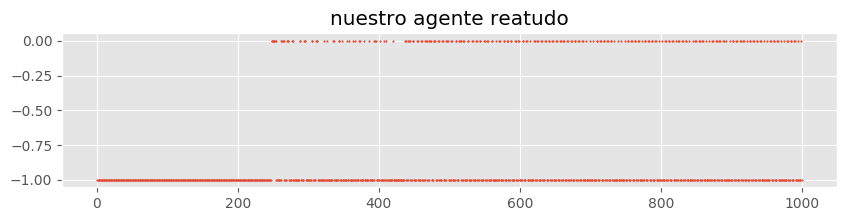

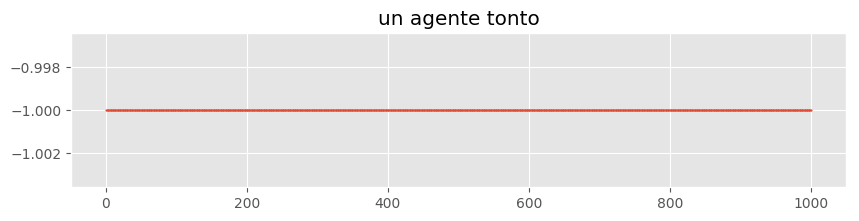

Cantidad de veces que nuestro agente llego a el objetivo en 1000 iteraciones 248
Cantidad de veces que el agente tonto a el objetivo en 1000 iteraciones 0


PyObject <matplotlib.collections.PathCollection object at 0x7f7238e44470>

In [51]:
println("Cantidad de veces que nuestro agente llego a el objetivo en 1000 iteraciones ",count(x->x==0.0, rewards))
println("Cantidad de veces que el agente tonto a el objetivo en 1000 iteraciones ",count(x->x==0.0, dumbrewards))
plt[:figure](figsize = (10,2))
plt[:title]("nuestro agente reatudo")
plt[:scatter]([ i for i in 1:1000],rewards, s = 1)
plt[:figure](figsize = (10,2))
plt[:title]("un agente tonto")
plt[:scatter]([i for i in 1:1000], dumbrewards,s =1)

# conclusiones
--- 

El tile coding funciona muy bien para nuestro problema, lastimosamente la capacidad computacional de mi ordenador no es la suficiente para poder entrenar multiples veces con distintos valores de epsilon gama bins. pero con lo que nosotros hemos logrado es lo suficiente para saber que q learning es una buena manera para resolver el problema si tenemos el suficiente poder de computo y tiempo para hacer el entrenamiento.
Seria bueno ver el problema este solucionado con double q learning y deep q learning que deberian de ser mucho mejores que el q learning por si solo